## Pearson Anomaly Correlation Coefficient Calculation Notebook

#### Import necessary packages

In [263]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import climpred
import utils
import cartopy
import geopandas as gpd
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from shapely.geometry import mapping
import pandas as pd

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Read in the ERA5 dataset retrieved for 1979-2010 period

In [264]:
ds = xr.open_dataset(r'data/adaptor.mars.internal-1643038411.451249-23736-8-64265746-33fc-46c1-90e3-7e98f040e022.nc')

#### Get the variable of interest and subset the dataset

The ERA5 dataset used in this analysis consists of the temperature ($t$) and geopotential ($z$) variables defined at two specific pressure levels ($500$ and $850$ hPa) with values four times a day ($00UTC$, $06UTC$, $12UTC$, $18UTC$) between the years $1979$-$2010$.  

For the calculation of the Pearson Anomaly Correlation Coefficient, we make use the temperature and geopotential variables defined at 850 hPa and 500 hPa, respectively.

In [265]:
ds1_subset = ds['t'].sel(latitude=slice(44, 34), longitude=slice(24,45), 
                     level=850, time=ds.time.dt.hour==12)

ds2_subset = ds['z'].sel(latitude=slice(44, 34), longitude=slice(24,45), 
                     level=500, time=ds.time.dt.hour==12)

Perform unit transformations. (Kelvin to &deg;C and Geopotential to Geopotential Height)

In [266]:
ds1_subset = ds1_subset - 273.15 # temperature in C
ds2_subset = ds2_subset/utils.g # geopotential height

Check if the dimensions of the data arrays match. Since we use the variables from the same dataset, they match in our case. Nevertheless, it is always a good practise to check the dimension names beforehand. We use a function from util.py

In [267]:
utils.check_dim_consistency(ds1_subset, ds2_subset)

data dims match, you can continue


#### Match dataset's grids

We will reproject $data$'s grids onto $match\_data$'s and match them, given that the calculation of correlation coefficient between two datasets at each individual grid point requires same grid structure (i.e., individual grids in each dataset should be defined at the same points). Again, the grids in our datasets match in this analysis.

In [268]:
ds1_subset_reprojected = reproject_match_rio(data=ds1_subset, match_data=ds2_subset,
                                 data_proj=utils.basic_crs_info_2, match_data_proj=utils.basic_crs_info_2)

Rioxarray's $reproject\_match$ method renames the latitude-longitude coordinates as y-x. Therefore, we better check again if the dimension names match.

In [269]:
# reprojection changes the name of the dims lat to y; lon to x
utils.check_dim_consistency(ds1_subset_reprojected, ds2_subset)

AssertionError: data dims do not match, consider matching

We get the error `data dims do not match, consider matching`. So let's match the dimension names again.

In [270]:
ds1_subset_reprojected = utils.match_latlon_dims(ds1_subset_reprojected)

#### Calculate anomalies

Use `get_anomaly` function from utils. It requires the input data, for which the anomalies will be calculated; the climatological data (i.e., the reference data for anomaly calculation); anomaly type (i.e., monthly, yearly, or daily anomalies depending on the dataset being used); and resampling method (i.e., climatological mean or climatological sum depending on the dataset being used).

In [271]:
ds1_anom = utils.get_anomaly(data=ds1_subset_reprojected, climatology=ds1_subset_reprojected, 
                             anomaly_type='month', resample_by='mean')
ds2_anom = utils.get_anomaly(data=ds2_subset, climatology=ds2_subset, 
                             anomaly_type='month', resample_by='mean')

#### Calculate Pearson Anomaly Correlation Coefficient

The pearson anomaly correlation coefficient corresponds to the pearson correlation coefficient calculated with the anomaly data. We make use of the `climpred` library for calculating the Pearson's product moment correlation coefficient. It is worth noting that there are different ways to express the anomaly correlation coefficient. In other words, while it is possible to calculate the anomaly correlation coefficient at each individual grid point for the given period, it is also possible to get a single anomaly correlation coefficient value for each year (i.e., spatially averaged anomaly correlation coefficient).

Firstly, we calculate the anomaly correlation coefficients for each grid points.

In [272]:
# get pearson acc for the whole period at each individual grid point
pacc_spatial = climpred.metrics._pearson_r(ds1_anom, ds2_anom, dim='time')

#### Interpolate dataset

Interpolate the correlation coefficient dataset to get a more eye-catching plot.

In [273]:
pacc_spatial_interp = utils.interpolate_xy(pacc_spatial, 'longitude', 'latitude', 4)

#### Visualize the anomaly correlation data array

Read in the shapefiles 

In [274]:
turkey_shape = Reader(r'data/shapefile/turkey_provinces.shp')
sea_shape = Reader(r'data/shapefile/World_Seas_IHO_v3.shp')

In [275]:
turkey_shape_df = gpd.read_file(r'data/shapefile/turkey_provinces.shp')

We are going to clip our data to the borders of Turkey. For this, we need to write the crs information

In [276]:
pacc_spatial_interp = pacc_spatial_interp.rio.write_crs(utils.basic_crs_info_2)
pacc_spatial_interp = pacc_spatial_interp.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')

Clip the data 

In [277]:
pacc_spatial_turkey = pacc_spatial_interp.rio.clip(turkey_shape_df.geometry.apply(mapping), pacc_spatial_interp.rio.crs, drop=True, invert=False)

Text(0.5, 1.0, 'Pearson Anomaly Correlation between 850 hPa Temperature and 500 hPa Geopotential Height')

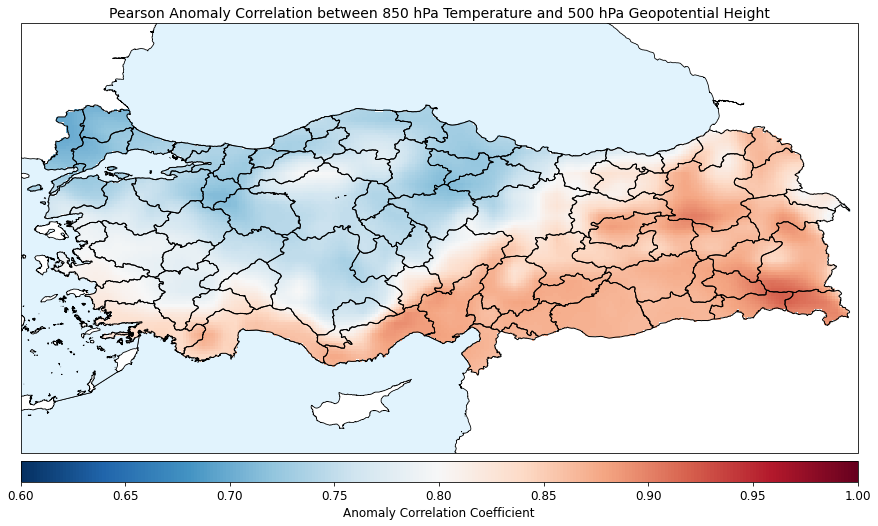

In [278]:
f, ax = plt.subplots(1, 1, figsize=(15, 15),  subplot_kw={'projection': cartopy.crs.PlateCarree()})

# plot
plot_obj = pacc_spatial_turkey.plot(ax=ax, facecolor="gray",
                                    transform=cartopy.crs.PlateCarree(),
                                    add_colorbar=False,
                                    cmap='RdBu_r',
                                    vmin=0.6,
                                    vmax=1)

# colorbar details
cb = plt.colorbar(plot_obj, shrink= 1, pad= 0.01,
                  aspect=40, orientation='horizontal')
cb.ax.tick_params(labelsize='large')
cb.set_label(label='Anomaly Correlation Coefficient', size='large')

# add shapes
shape_feature_turkey = ShapelyFeature(turkey_shape.geometries(),
                                      cartopy.crs.PlateCarree(), facecolor='none',
                                      edgecolor = 'black', linewidth = 1, zorder = 1)
shape_feature_sea = ShapelyFeature(sea_shape.geometries(),
                                   cartopy.crs.PlateCarree(), facecolor='#e1f3fd',
                                   edgecolor = 'black', linewidth = 0.8, zorder = 0.9)

ax.add_feature(shape_feature_turkey)
ax.add_feature(shape_feature_sea)

ax.set_extent([25.5, 45, 34, 44])
ax.set_title('Pearson Anomaly Correlation between 850 hPa Temperature and 500 hPa Geopotential Height', size=14)

Secondly, we calculate the anomaly correlation coefficients for each year using the spatially averaged anomaly values.

In [279]:
# get yearly spatially-averaged acc values
data_years = np.unique(ds1_anom.time.dt.year)
acc_yearly_list = list()

for year in data_years:
    
    ds1_anom_year = ds1_anom.groupby("time.year")[year]
    ds2_anom_year = ds2_anom.groupby("time.year")[year]
    
    acc_year_val = climpred.metrics._pearson_r(ds1_anom_year, ds2_anom_year)
    
    acc_yearly_list.append(acc_year_val)
    
acc_yearly_list = np.array(acc_yearly_list)

Lastly, we calculate the anomaly correlation coefficients for each month using the spatially averaged anomaly values.

In [280]:
# get monthly spatially-averaged acc values
data_months = np.unique(ds1_anom.time.dt.month)
acc_monthly_list = list()

for month in data_months:
    
    ds1_anom_monthly = ds1_anom.groupby("time.month")[month]
    ds2_anom_monthly = ds2_anom.groupby("time.month")[month]
    
    acc_month_val = climpred.metrics._pearson_r(ds1_anom_monthly, ds2_anom_monthly)
    
    acc_monthly_list.append(acc_month_val)
    
acc_monthly_list = np.array(acc_monthly_list)

Create a basic pd DataFrame for plotting purposes

In [281]:
yearly_acc_df = pd.DataFrame({'yearly_acc': acc_yearly_list})
monthly_acc_df = pd.DataFrame({'monthly_acc': acc_monthly_list})

#### Visualize the yearly and monthly anomaly correlation coefficient values

First: Yearly

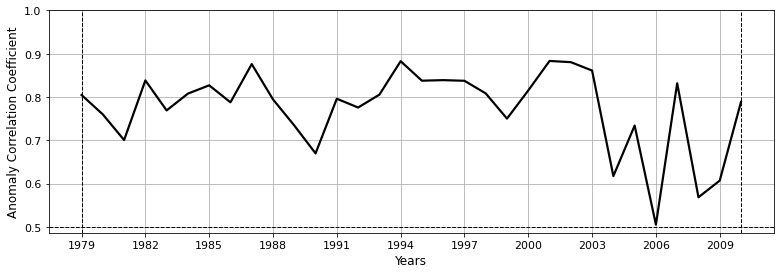

In [284]:
plt.rcParams['figure.figsize'] = 13, 9
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

yearly_acc_df['yearly_acc'].plot(ax=ax, color='black', linewidth=2.2)

ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)

ax.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
ax.axvline(x=0, linewidth=1, linestyle='--', color='black')
ax.axvline(x=31, linewidth=1, linestyle='--', color='black')

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Anomaly Correlation Coefficient', fontsize=12)

ax.set_xticks([i for i in range(0, len(acc_yearly_list), 3)])
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xticklabels([i for i in range(1979, 2011, 3)])

ax.grid()

Second: Monthly

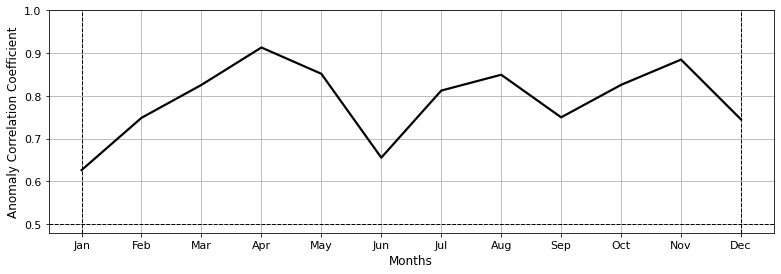

In [285]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.rcParams['figure.figsize'] = 13, 9
fig = plt.figure()
ax = fig.add_subplot(2,1,1)

monthly_acc_df['monthly_acc'].plot(ax=ax, color='black', linewidth=2.2)
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)

ax.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
ax.axvline(x=0, linewidth=1, linestyle='--', color='black')
ax.axvline(x=11, linewidth=1, linestyle='--', color='black')

ax.set_xlabel('Months', fontsize=12)
ax.set_ylabel('Anomaly Correlation Coefficient', fontsize=12)

ax.set_xticks([i for i in range(len(acc_monthly_list))])
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xticklabels(months)
ax.grid()

## END